# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [3]:
# These are all of the files you are given
df_tr = pd.read_csv("train.csv")

In [4]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [16]:
df_tr[df_tr["DAY_TYPE"] != "A"]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE


### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [6]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
cab_data = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
cab_dict = {}
for i in range(1, 64):
    cab_dict[i] = (int((float(cab_data[cab_data["ID"] == i].values[0][2] - 41.1)) * 1000), int((cab_data[cab_data["ID"] == i].values[0][3] + 8.6) * 1000))


In [7]:
min(i[0] for i in cab_dict.values())

40

In [ ]:
# def get_lat_long(x):
#     i = x["ORIGIN_STAND"]
#     if (i != i): return np.NaN, np.NaN
#     i = int(i)
#     return cab_dict[i][0], cab_dict[i][1]

# df_tr[["LAT", "LONG"]] = df_tr[["ORIGIN_STAND"]].apply(get_lat_long, axis=1, result_type="expand")

### Create a Prediction File

In [7]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617510816


In [8]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

In [25]:
df_tr[["LAT", "LONG"]].values[2]

array([nan, nan])

Using: 1692771/1710670


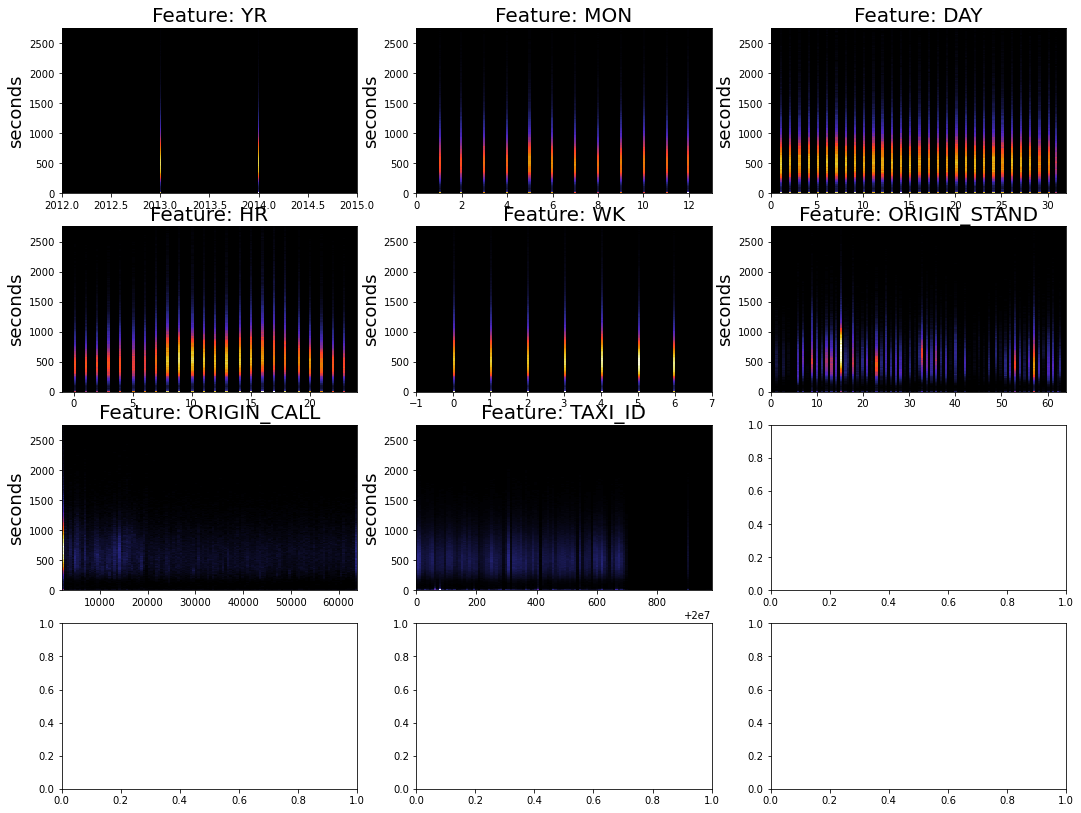

In [9]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND", "ORIGIN_CALL", "TAXI_ID"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


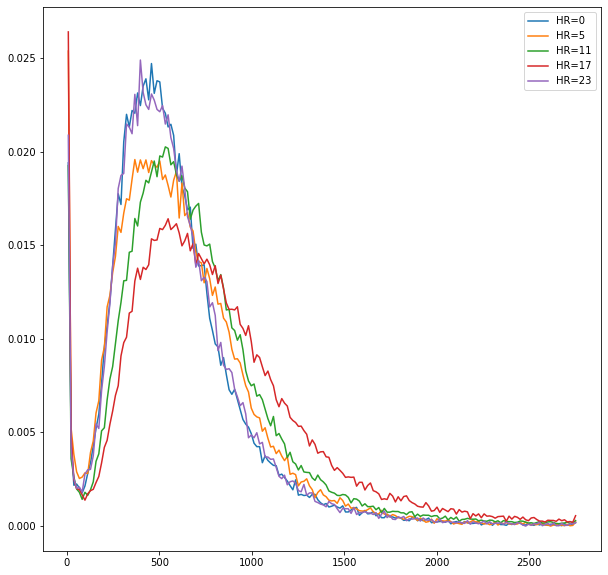

In [10]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

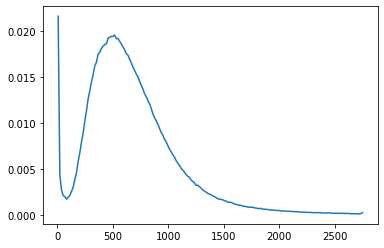

In [170]:
histogram, bin_boundary = np.histogram(df_trimmed["LEN"], bins=buckets)
histogram = histogram / len(df_trimmed)
# The center is the left_bound and right_bound of a bucket
bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
plt.plot(bin_centers, histogram)
plt.show()

In [123]:
def get_coordinate_list(polyline):
    return list(eval(polyline["POLYLINE"])) # don't use eval usually, BUT I am too lazy for actual parsing.

get_coordinate_list(df_trimmed.iloc[0])

[[-8.618643, 41.141412],
 [-8.618499, 41.141376],
 [-8.620326, 41.14251],
 [-8.622153, 41.143815],
 [-8.623953, 41.144373],
 [-8.62668, 41.144778],
 [-8.627373, 41.144697],
 [-8.630226, 41.14521],
 [-8.632746, 41.14692],
 [-8.631738, 41.148225],
 [-8.629938, 41.150385],
 [-8.62911, 41.151213],
 [-8.629128, 41.15124],
 [-8.628786, 41.152203],
 [-8.628687, 41.152374],
 [-8.628759, 41.152518],
 [-8.630838, 41.15268],
 [-8.632323, 41.153022],
 [-8.631144, 41.154489],
 [-8.630829, 41.154507],
 [-8.630829, 41.154516],
 [-8.630829, 41.154498],
 [-8.630838, 41.154489]]

In [15]:
from tqdm import tqdm
min_lat = 9999999999
max_lat = -9999999999
min_long = 9999999999
max_long = -9999999999
for i in tqdm(range(len(df_trimmed))):
    coords = get_coordinate_list(df_trimmed.iloc[i])
    for coord in coords:
        lat = coord[0]
        long = coord[1]
        min_lat = min(min_lat, lat)
        min_long = min(min_long, long)
        max_lat = max(max_lat, lat)
        max_long = max(max_long, long)

100%|██████████| 1692771/1692771 [07:27<00:00, 3785.39it/s]


In [18]:
max_long

51.037119

In [19]:
min_long

31.992111

In [75]:
num_lat_buckets = 100
num_long_buckets = 100
lat_range = max_lat - min_lat
long_range = max_long - min_long

def get_bucket(lat, long):
    lat_bucket = int((lat - min_lat) / lat_range * num_lat_buckets)
    if (lat_bucket >= num_lat_buckets): # edge case due to floating point imprecision
        lat_bucket -= 1
    long_bucket = int((long - min_long) / long_range * num_long_buckets)
    if (long_bucket >= num_long_buckets):
        long_bucket -= 1
    return (lat_bucket, long_bucket)

In [76]:
get_bucket(max_lat, max_long)

(99, 99)

\*\*\*\* it, I'm going to calculate stdev

In [128]:
df_tr_shuffle = df_tr.sample(frac=1)
df_tr_shuffle

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
1017409,1391723083620000667,B,NaN,10.0,20000667,1391723083,A,False,"[[-8.60688,41.150178],[-8.607474,41.150034],[-...",255,2014,2,6,21,3
435673,1380884855620000305,A,5239.0,NaN,20000305,1380884855,A,False,"[[-8.607402,41.145426],[-8.60742,41.145543],[-...",1230,2013,10,4,11,4
109521,1374629988620000136,C,NaN,NaN,20000136,1374629988,A,False,"[[-8.614314,41.147109],[-8.614395,41.147136],[...",345,2013,7,24,1,2
1384955,1398705752620000453,C,NaN,NaN,20000453,1398705752,A,False,"[[-8.607006,41.146146],[-8.607033,41.146479],[...",495,2014,4,28,17,0
1173234,1394630397620000601,A,59730.0,NaN,20000601,1394630397,A,False,"[[-8.60382,41.175081],[-8.603829,41.175063],[-...",855,2014,3,12,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614921,1402524216620000455,B,NaN,60.0,20000455,1402524216,A,False,"[[-8.609571,41.151222],[-8.609517,41.151375],[...",300,2014,6,11,22,2
1103546,1393368212620000577,C,NaN,NaN,20000577,1393368212,A,False,"[[-8.614107,41.14071],[-8.613531,41.141214],[-...",1560,2014,2,25,22,1
906916,1389418828620000610,B,NaN,23.0,20000610,1389418828,A,False,"[[-8.612469,41.146056],[-8.612352,41.146047],[...",405,2014,1,11,5,5
825195,1387858144620000140,B,NaN,25.0,20000140,1387858144,A,False,"[[-8.617644,41.14629],[-8.617617,41.146218],[-...",870,2013,12,24,4,1


In [136]:
lat_sample = []
long_sample = []
for i in range(10000):
    row = df_tr_shuffle.iloc[i]
    coords = get_coordinate_list(row)
    for coord in coords:
        lat = coord[0]
        long = coord[1]
        lat_sample.append(lat)
        long_sample.append(long)

In [144]:
lat_stddev = np.std(lat_sample, ddof=1)
lat_mean = np.mean(lat_sample)
long_stddev = np.std(long_sample, ddof=1)
long_mean = np.mean(long_sample)

In [162]:
max_lat = lat_mean + 2.5 * lat_stddev
min_lat = lat_mean - 2.5 * lat_stddev
max_long = long_mean + 2.5 * long_stddev
min_long = long_mean - 2.5 * long_stddev

In [163]:
num_lat_buckets = 100
num_long_buckets = 100
lat_range = max_lat - min_lat
long_range = max_long - min_long

def get_bucket(lat, long):
    lat_bucket = int((lat - min_lat) / lat_range * num_lat_buckets)
    long_bucket = int((long - min_long) / long_range * num_long_buckets)
    return (lat_bucket, long_bucket)

In [164]:
heatmat = np.zeros((num_lat_buckets, num_long_buckets))
df_tr_no_missing = df_tr[df_tr["MISSING_DATA"] == False]
for i in tqdm(range(len(df_tr_no_missing))):
    row = df_tr_no_missing.iloc[i]
    coords = get_coordinate_list(row)
    for coord in coords:
        lat = coord[0]
        long = coord[1]
        (lat_bucket, long_bucket) = get_bucket(lat, long)
        try:
            heatmat[lat_bucket][long_bucket] += 1
        except IndexError: continue

100%|██████████| 1710660/1710660 [08:45<00:00, 3255.66it/s]


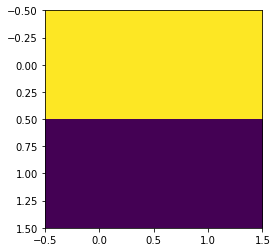

In [168]:
plt.imshow(np.array([[1, 1], [0,0]]))

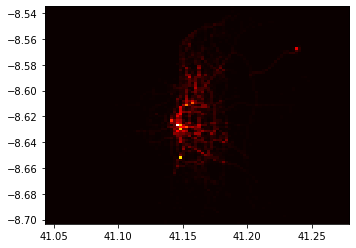

In [169]:
plt.imshow(heatmat, cmap='hot', interpolation='nearest', extent=[min_long, max_long, min_lat, max_lat])
plt.show()